# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np
import pandas as pd
import time
# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

#### Target function and wrapper

In [6]:
H0    = 1.0723 #73.3 #1.0723 # #km/s/Mpc
Omega = 1.315 #0.315 #1.315 # 
c     = 1.13 #1.13 # 3e5 # km/s

#H0b    = 0.8669
#Omegab = 4.7490
#c      = 1.13
#
#H0    = 73.3 #1.0723 # #km/s/Mpc
#Omega = 0.315 #1.315 # 
#c     = 3e5 # km/s
#
#H0b    = 40.9585
#Omegab = 4.7270
#c      = 3e5


H0    = torch.tensor(np.array(H0)).to(DEVICE)
Omega = torch.tensor(np.array(Omega)).to(DEVICE)
c     = torch.tensor(np.array(c)).to(DEVICE)

f_LCDMb   = lambda X: (H0b**2)*(Omegab*(X[0])**3 + 1 - Omegab)
f_LCDM    = lambda X: (H0**2)*(Omega*(X[0])**3 + 1 - Omega) # (H0**2)*Omega*x**3 + (H0**2)*(1 - Omega) # = c0*x**3 + c1

target_program_str = ["mul", "n2", "H0", "sub", "add", "mul", "Omega", "mul", "x", "n2", "x", "1", "Omega"]
print(len(target_program_str))

13


In [7]:
def wrapper_func (func, X):
    z = X[0]
    def H_func (z):
        X_modif = torch.stack((z+1.,), dim=0)
        res = torch.sqrt(func(X_modif))
        return res  # in Mpc
    integrand = lambda zp: 1/H_func(zp)
    y_primitive = torch.cumulative_trapezoid(y=integrand(z), x=z)
    integral = torch.cat((torch.tensor([y_primitive[0]]), y_primitive))
    #integral  = torch.stack(my_ugly_trapz_cumsum(integrand, z))
    dL = (1+z)*integral # in Mpc
    #mu_z = 5*torch.log10(dL*c)-5*torch.log10(torch.tensor(1e-5)) # 10 pc = 1e-5 Mpc
    mu_z = 5*torch.log10(dL)+5*torch.log10(c)-5*torch.log10(torch.tensor(1e-5)) # 10 pc = 1e-5 Mpc
    return mu_z

#### Observational data

In [8]:
df = pd.read_csv("Scolnic_2018.txt", sep=" ", index_col=False)
df = df.sort_values(by="zcmb")

In [9]:
z_array  = df["zcmb"].to_numpy()
mb_scale = +0.5 #19.253 # https://iopscience.iop.org/article/10.3847/2041-8213/ac5c5b
mu_array = df["mb"] + mb_scale

X_array = np.stack((z_array,), axis=0)
y_array = mu_array

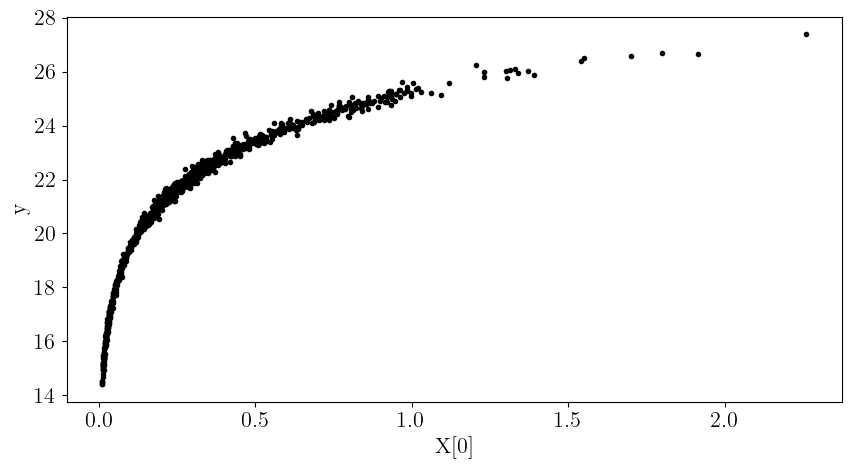

In [10]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

(array([231., 239., 221., 107.,  60.,  51.,  43.,  42.,  25.,  11.,   2.,
          3.,   7.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([0.01012   , 0.11725714, 0.22439429, 0.33153143, 0.43866857,
        0.54580571, 0.65294286, 0.76008   , 0.86721714, 0.97435429,
        1.08149143, 1.18862857, 1.29576571, 1.40290286, 1.51004   ,
        1.61717714, 1.72431429, 1.83145143, 1.93858857, 2.04572571,
        2.15286286, 2.26      ]),
 <BarContainer object of 21 artists>)

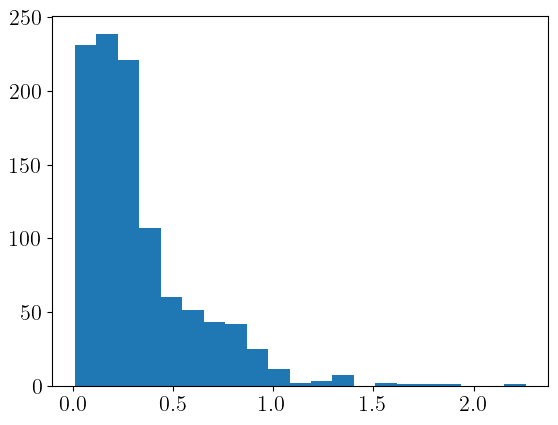

In [11]:
plt.hist(z_array, bins=21)

In [12]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

tensor(422.2296, dtype=torch.float64)


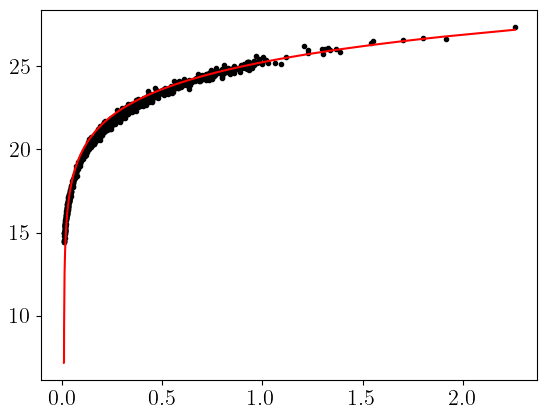

In [13]:
y_pred = wrapper_func(f_LCDM, X)
plt.plot(X[0], y, "k."     , label="Scolnic_2018")
plt.plot(X[0], y_pred, "r-", label="LCDM")
mse = torch.sum((y_pred - y)**2)
print(mse)

In [14]:
#y_pred = wrapper_func(f_LCDMb, X)
#plt.plot(X[0], y,      "k.", label="Scolnic_2018")
#plt.plot(X[0], y_pred, "r-", label="LCDM")
#mse = torch.sum((y_pred - y)**2)
#print(mse)

#### Synthetic data

In [15]:
#z_array  = np.linspace(0.01, 2.5, 1000)
#X_array  = np.stack((z_array,), axis=0)

In [16]:
#t0 = time.perf_counter()
#N = 1000
#for _ in range(N):
#    # Output of symbolic function to guess
#    y = wrapper_func(f_LCDM, X).to(DEVICE)
#t1 = time.perf_counter()
#print((t1-t0)/N)

In [17]:
## ------ Vectors ------
## Stack of all input variables
#X = torch.tensor(X_array).to(DEVICE)
#y = wrapper_func(f_LCDM, X).to(DEVICE)
#y += (torch.rand_like(y) - 0.5)*0.5



In [18]:
#plt.plot(X[0], y, "k.", label="Synthetic LCDM")
#plt.plot(X[0], wrapper_func(f_LCDM, X), "r-", label="LCDM")

#### Constants

In [19]:
# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)

## Run config

### Library config

In [20]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"x" : 0         ,},
                "input_var_units"      : {"x" : [0, 0, 0] ,},
                "input_var_complexity" : {"x" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"H0"              , "Omega"              ,},
                "free_constants_init_val"   : {"H0" : 1.         , "Omega" : 1.         ,},
                "free_constants_units"      : {"H0" : [0, -1, 0] , "Omega" : [0, 0, 0]  ,},
                "free_constants_complexity" : {"H0" : 1.         , "Omega" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, -1, 0],
                  "superparent_name"  : "sqrtH",
                }

### Free constant optimizer config

In [21]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 50,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }


### Learning config

In [22]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [23]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [24]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : 5, #int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

### Priors config

In [25]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 6, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [4,] }),
                 ]

### Cell config

In [26]:
cell_config = {
    "hidden_size"    : 128,
    "n_layers"       : 1,
    "is_lobotomized" : True,
}

### Logger

In [27]:
save_path_training_curves = 'expansion_law_curves.png'
save_path_log             = 'expansion_law.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [28]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

In [29]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


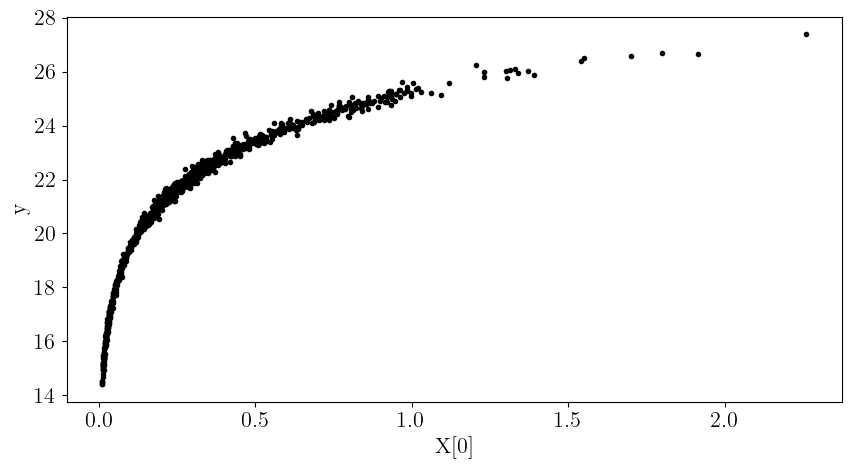

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'H0': 12, 'Omega': 13, 'x': 14}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 H0 Omega x sqrtH dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 6, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([1, 1048]) 
y_target : torch.Size([1048])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' 

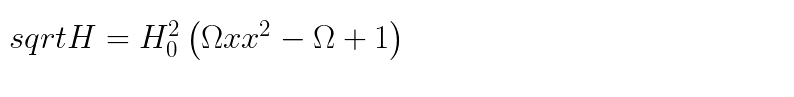

Simplified expression:


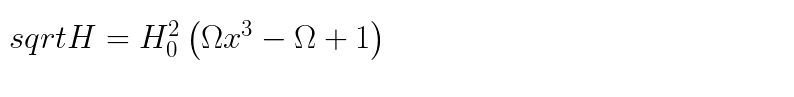

free const opti time = 150.901208 ms
free constants found: tensor([0.8669, 4.7490], dtype=torch.float64, requires_grad=True)


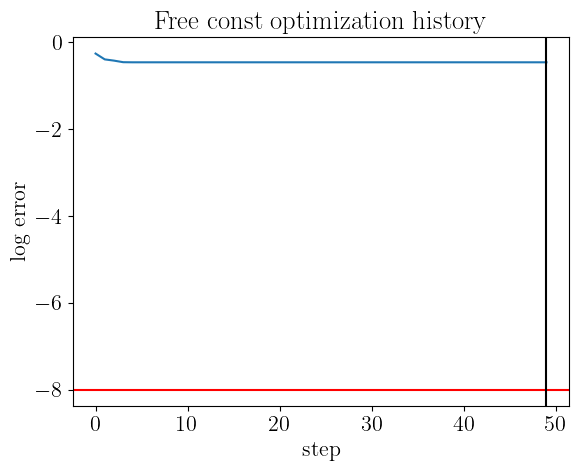

Ideal reward : 0.8191991169744104


In [30]:
target_program = benchmark.sanity_check(X, y, run_config, candidate_wrapper = wrapper_func, target_program_str=target_program_str, expected_ideal_reward=0.80)

## Run

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 34 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 42 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 44 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 58 -> r = 0
  wa

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00000 ===========
-> Time 3.75 s

Overall best  at R=0.851319
-> Raw expression : 
           x            
────────────────────────
⎛                   0.5⎞
⎜⎛          1      ⎞   ⎟
⎜⎜x + ─────────────⎟   ⎟
⎜⎝    Ω + Ω + x + 1⎠   ⎟
⎜──────────────────────⎟
⎝          H₀          ⎠

Best of epoch at R=0.851319
-> Raw expression : 
           x            
────────────────────────
⎛                   0.5⎞
⎜⎛          1      ⎞   ⎟
⎜⎜x + ─────────────⎟   ⎟
⎜⎝    Ω + Ω + x + 1⎠   ⎟
⎜──────────────────────⎟
⎝          H₀          ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 16 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 87 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 89 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 96 -> r = 0
  wa

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00001 ===========
-> Time 63.64 s

Overall best  at R=0.851319
-> Raw expression : 
           x            
────────────────────────
⎛                   0.5⎞
⎜⎛          1      ⎞   ⎟
⎜⎜x + ─────────────⎟   ⎟
⎜⎝    Ω + Ω + x + 1⎠   ⎟
⎜──────────────────────⎟
⎝          H₀          ⎠

Best of epoch at R=0.837465
-> Raw expression : 
                 0.5
⎛  2       1    ⎞   
⎜H₀  - ─────────⎟   
⎜              2⎟   
⎜        ⎛ 0.5⎞ ⎟   
⎜        ⎜1   ⎟ ⎟   
⎜      x⋅⎜────⎟ ⎟   
⎝        ⎝ H₀ ⎠ ⎠   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 0 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 5 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 12 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 21 -> r = 0
  warn

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00002 ===========
-> Time 58.01 s

Overall best  at R=0.851319
-> Raw expression : 
           x            
────────────────────────
⎛                   0.5⎞
⎜⎛          1      ⎞   ⎟
⎜⎜x + ─────────────⎟   ⎟
⎜⎝    Ω + Ω + x + 1⎠   ⎟
⎜──────────────────────⎟
⎝          H₀          ⎠

Best of epoch at R=0.833853
-> Raw expression : 
  ⎛  0.5        ⎞     Ω 
  ⎜H₀   ⋅H₀     ⎟    ℯ  
- ⎜──────── - H₀⎟ + ────
  ⎜  0.5        ⎟   ⎛1 ⎞
  ⎝H₀   ⋅x      ⎠   ⎜──⎟
                    ⎝H₀⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 14 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 35 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 40 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 41 -> r = 0
  wa

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00003 ===========
-> Time 48.23 s

Overall best  at R=0.852386
-> Raw expression : 
                                     0.5
   ⎛        ⎛                0.5  1⎞⎞   
H₀⋅⎝-Ω + cos⎝(-Ω + x + x - 1)   ⋅ℯ ⎠⎠   

Best of epoch at R=0.852386
-> Raw expression : 
                                     0.5
   ⎛        ⎛                0.5  1⎞⎞   
H₀⋅⎝-Ω + cos⎝(-Ω + x + x - 1)   ⋅ℯ ⎠⎠   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 9 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 82 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 85 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 89 -> r = 0
  war

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00004 ===========
-> Time 56.09 s

Overall best  at R=0.895744
-> Raw expression : 
                         0.5
⎛  ⎛       0.5   ⎞      ⎞   
⎜  ⎜    cos   (x)⎟   1  ⎟   
⎜1⋅⎜x - ─────────⎟⋅─────⎟   
⎜  ⎝        Ω    ⎠     2⎟   
⎜                  ⎛x ⎞ ⎟   
⎜                  ⎜──⎟ ⎟   
⎝                  ⎝H₀⎠ ⎠   

Best of epoch at R=0.895744
-> Raw expression : 
                         0.5
⎛  ⎛       0.5   ⎞      ⎞   
⎜  ⎜    cos   (x)⎟   1  ⎟   
⎜1⋅⎜x - ─────────⎟⋅─────⎟   
⎜  ⎝        Ω    ⎠     2⎟   
⎜                  ⎛x ⎞ ⎟   
⎜                  ⎜──⎟ ⎟   
⎝                  ⎝H₀⎠ ⎠   




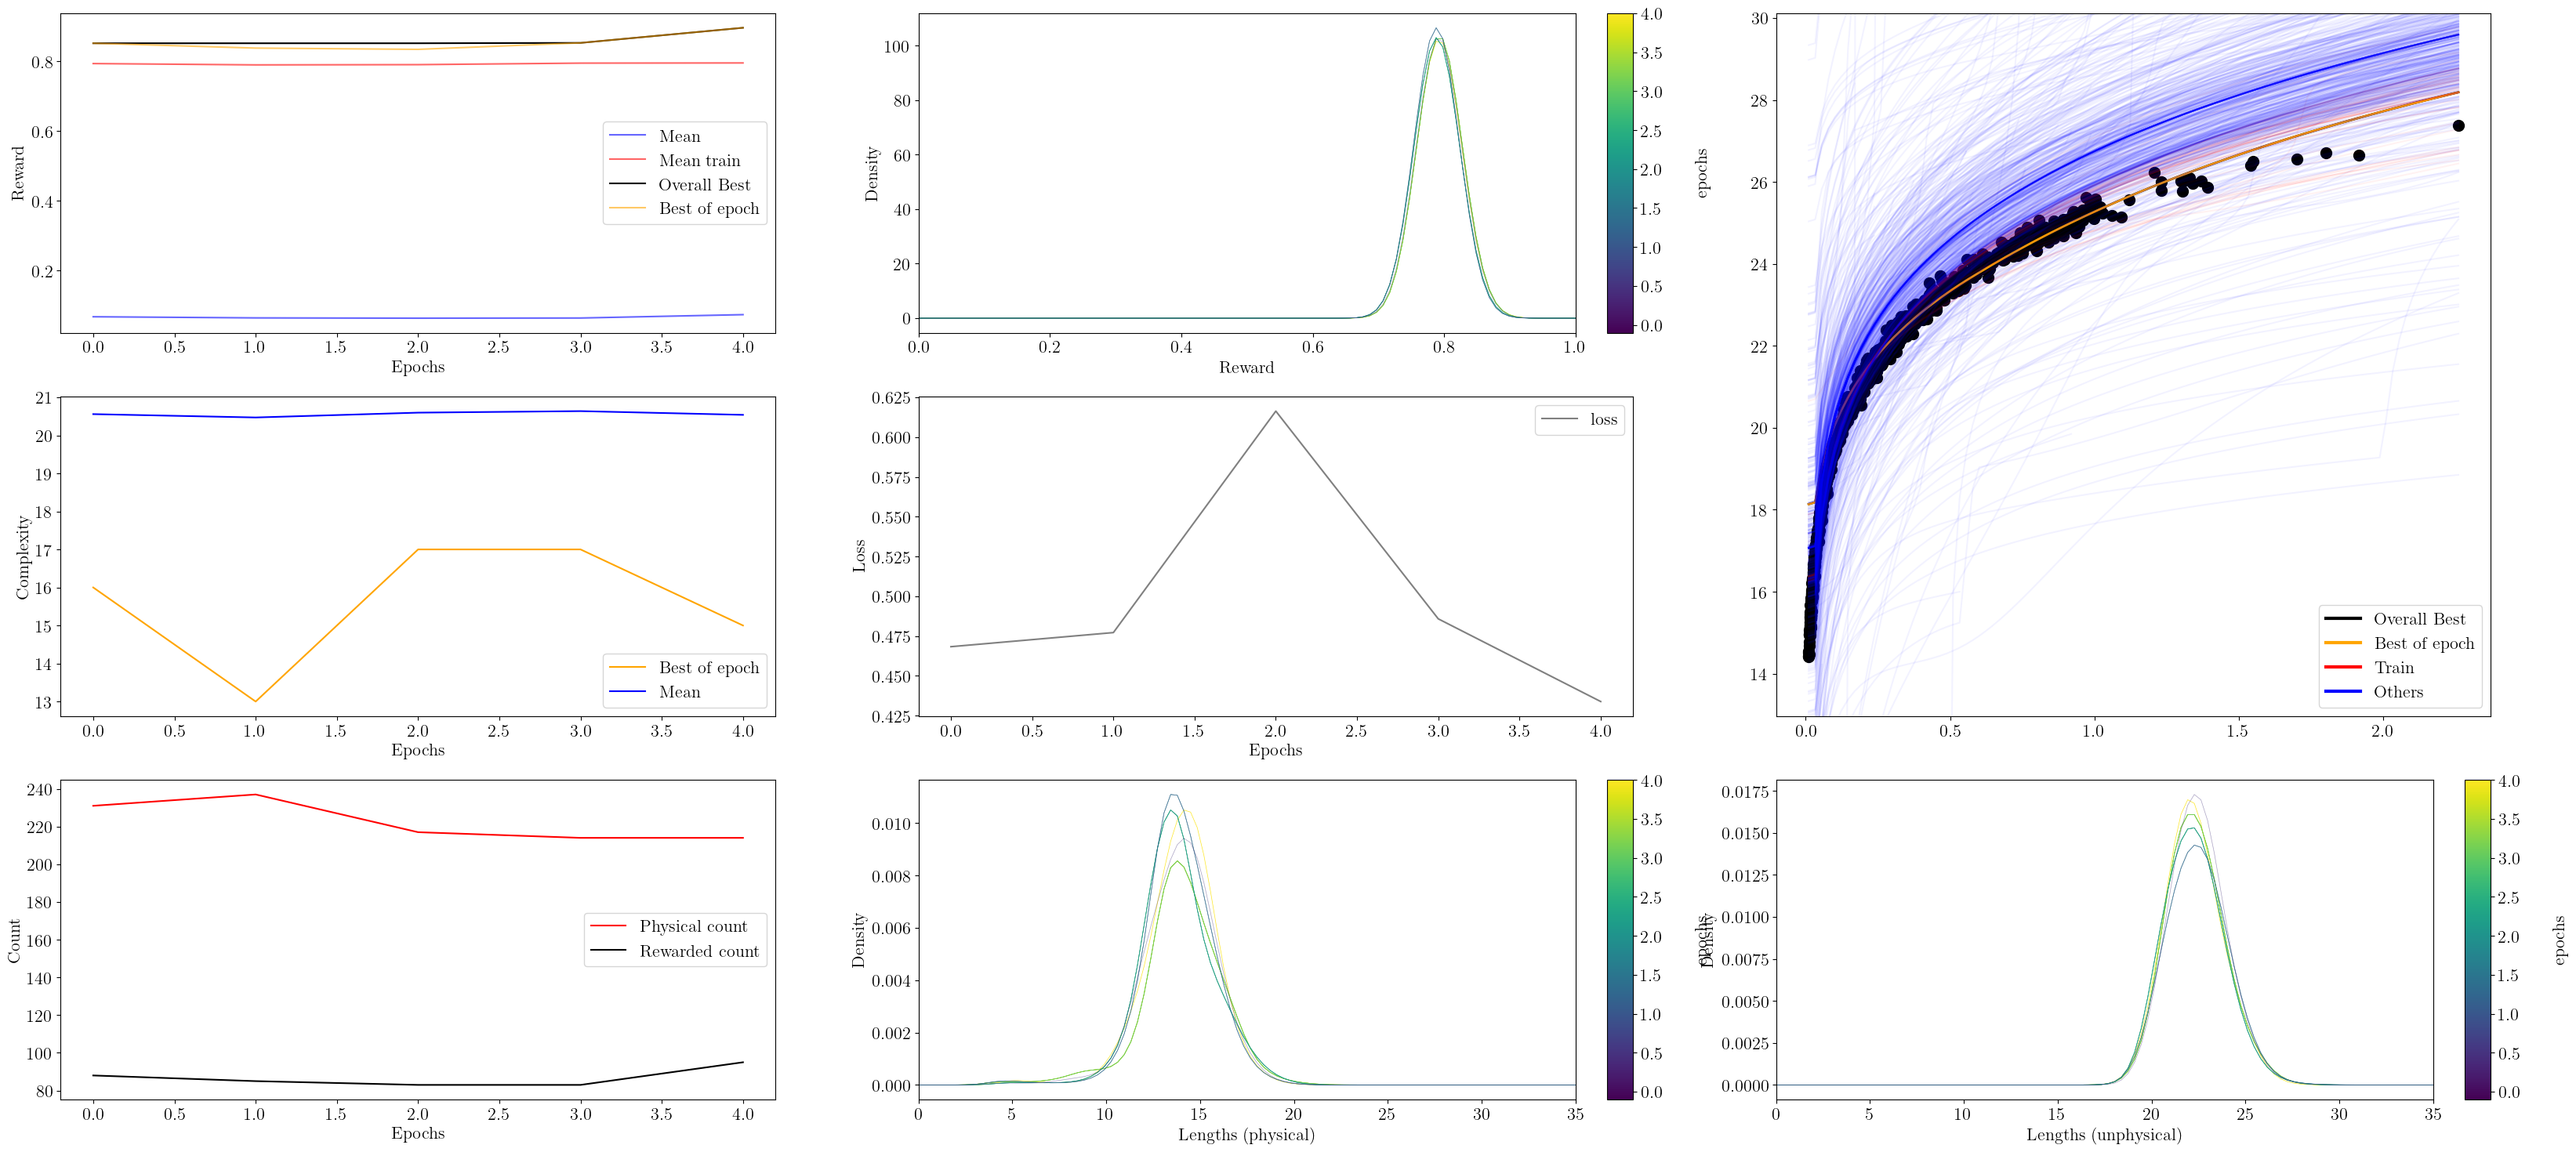

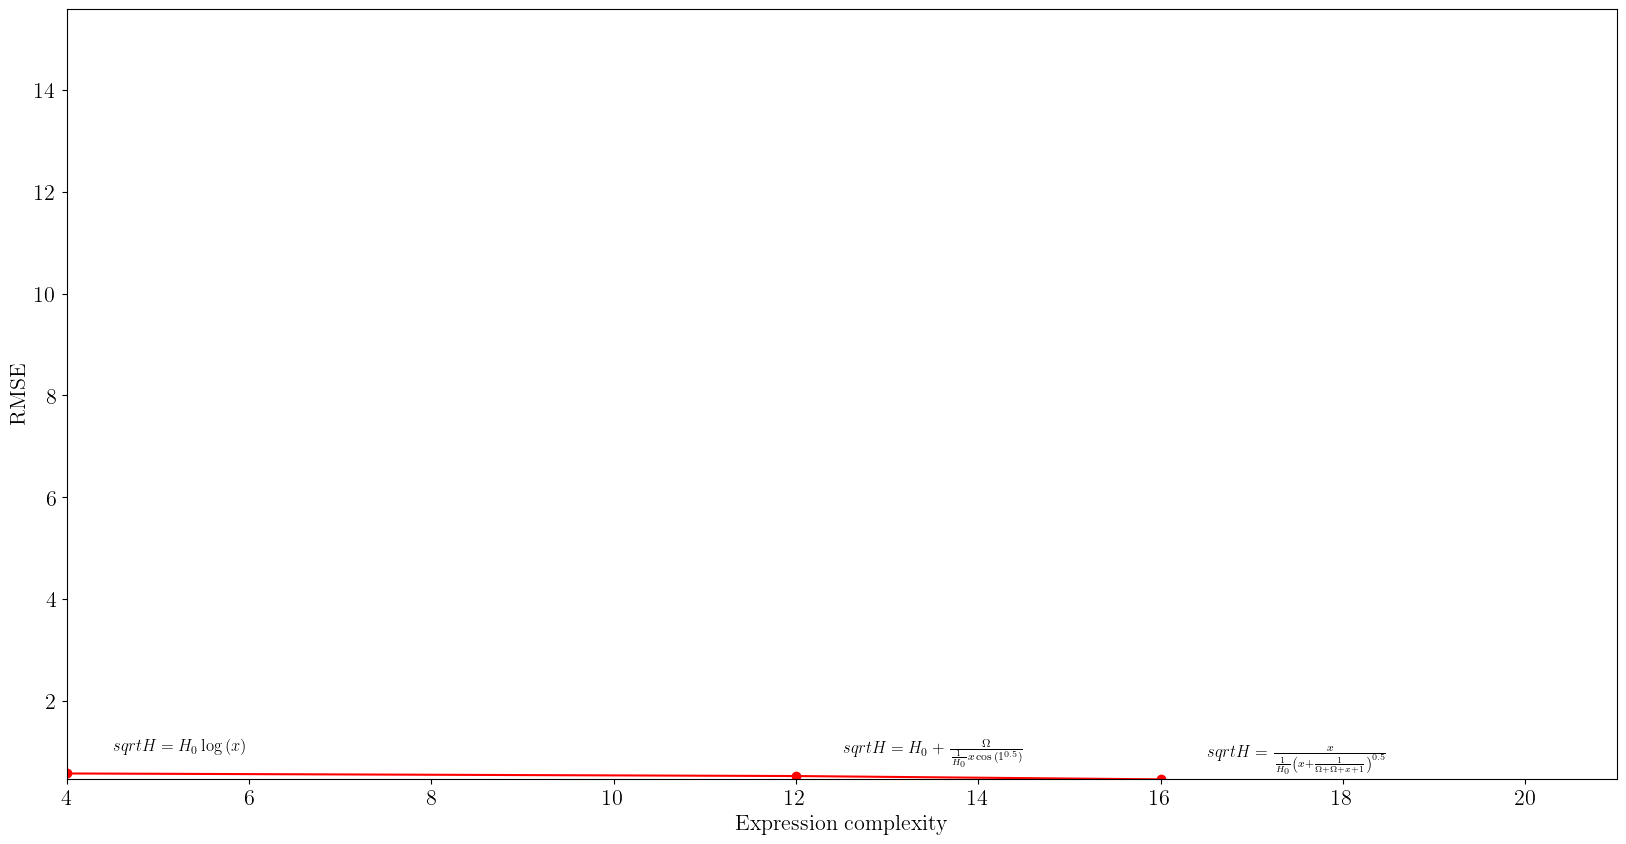

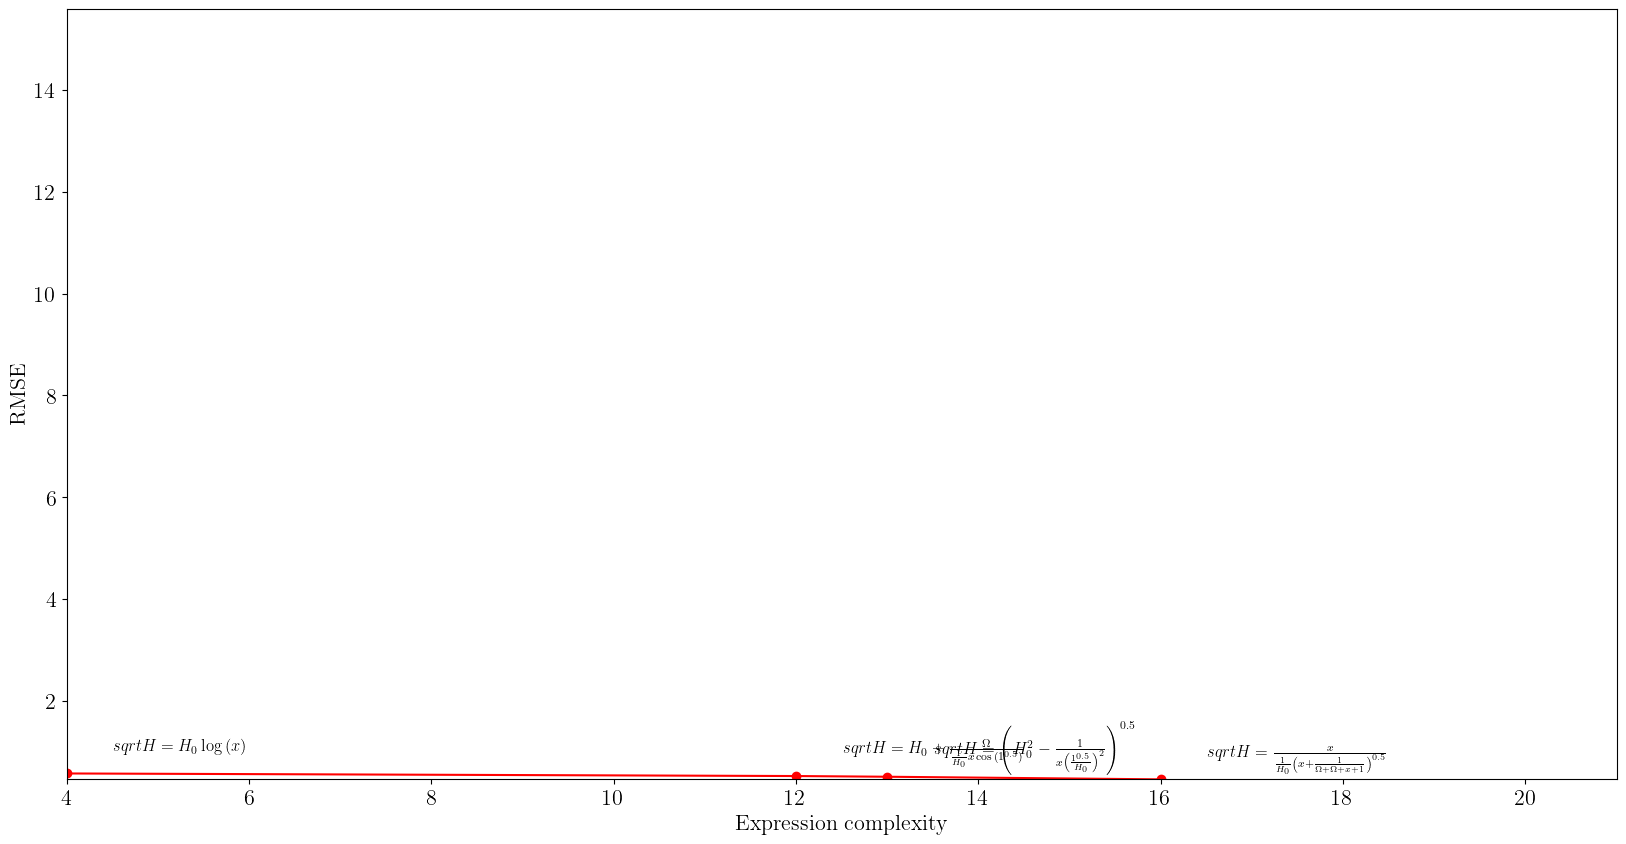

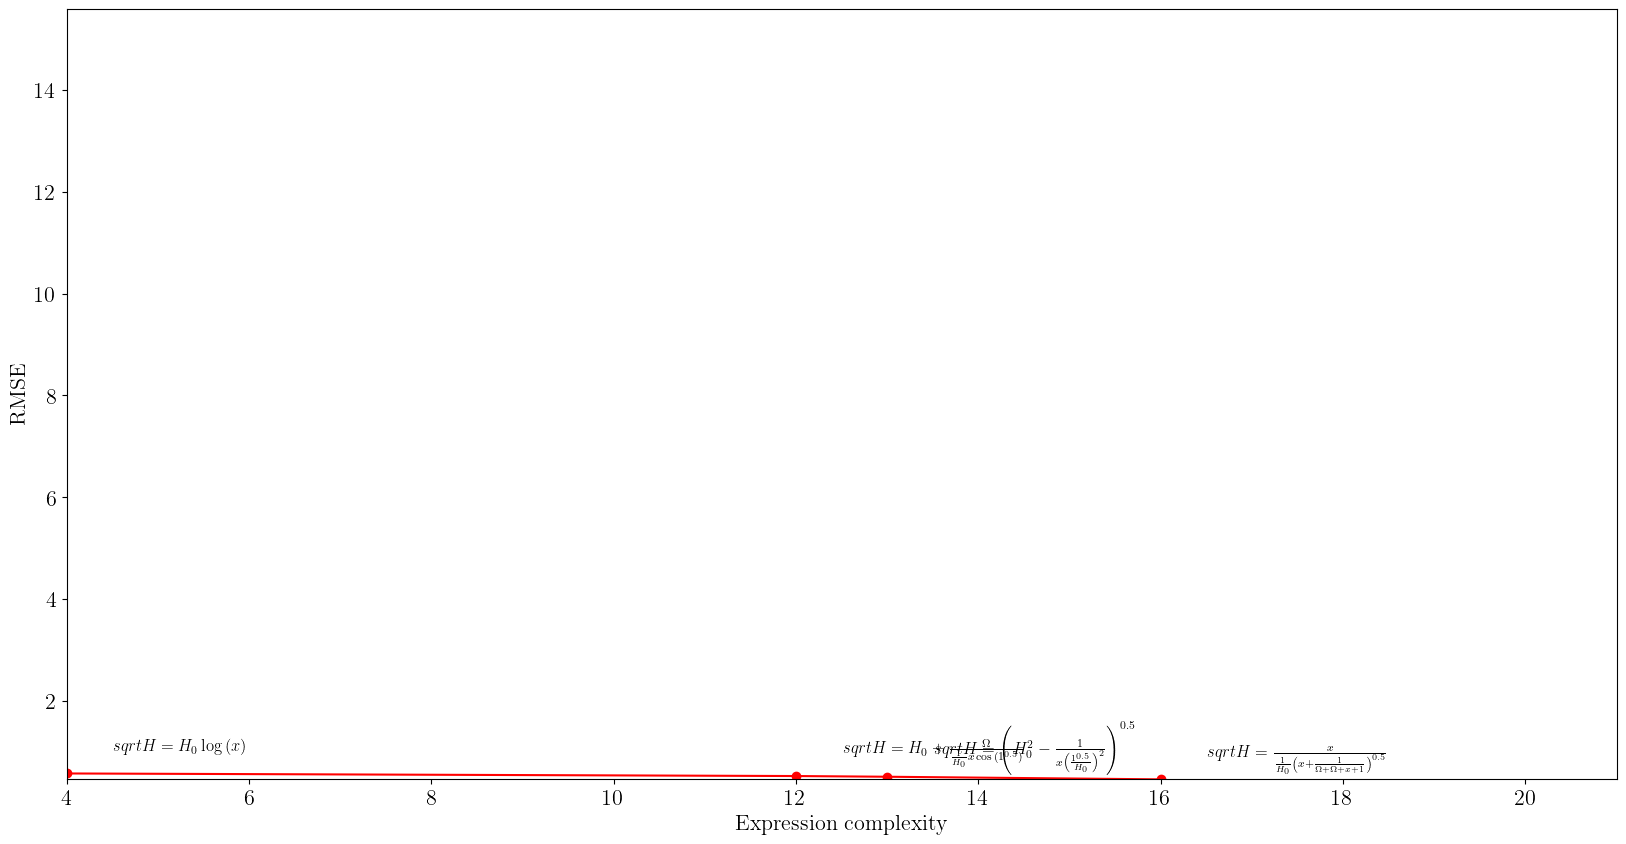

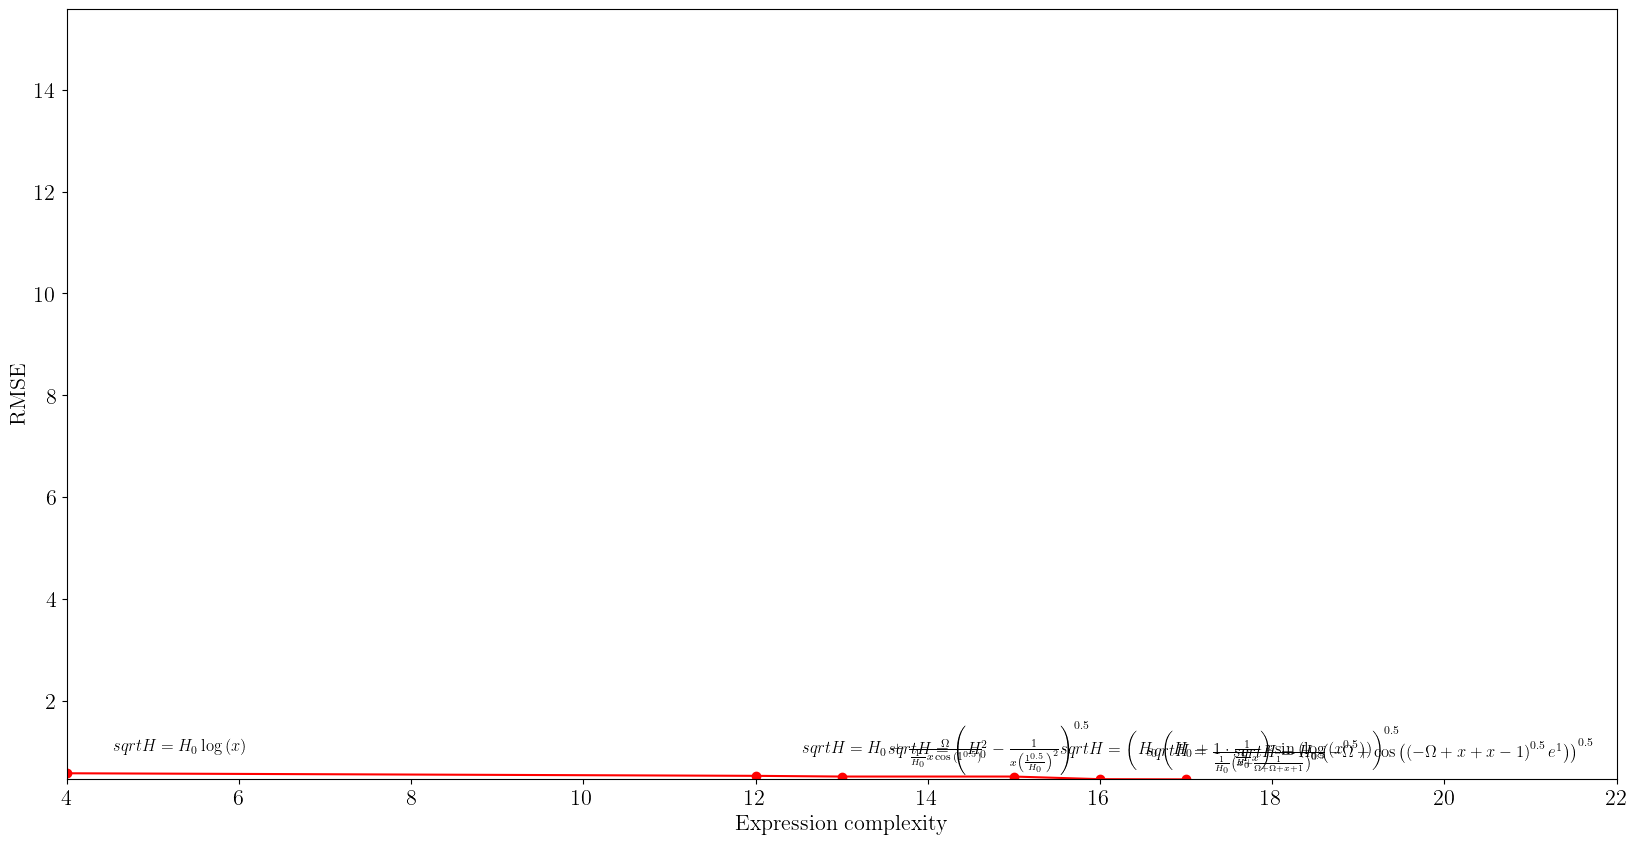

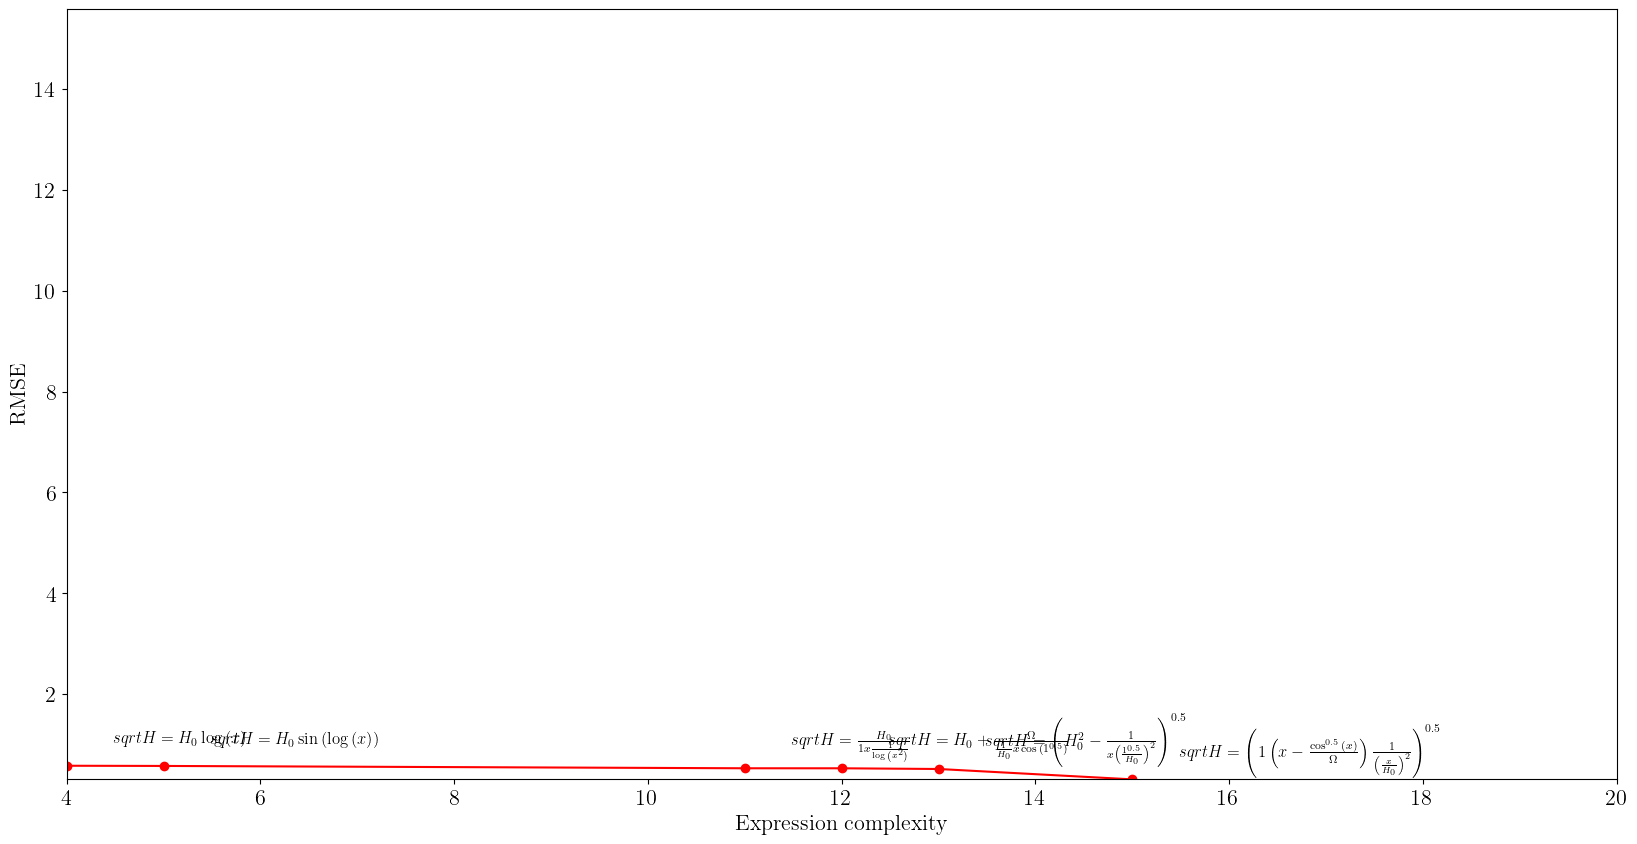

In [31]:
rewards, candidates = physo.fit(X, y, run_config, 
                                candidate_wrapper = wrapper_func, 
                                stop_reward = 1., 
                                stop_after_n_epochs = int(1e9))

## Results

### Run plot

Unable to draw one or more prog curve on monitoring plot.


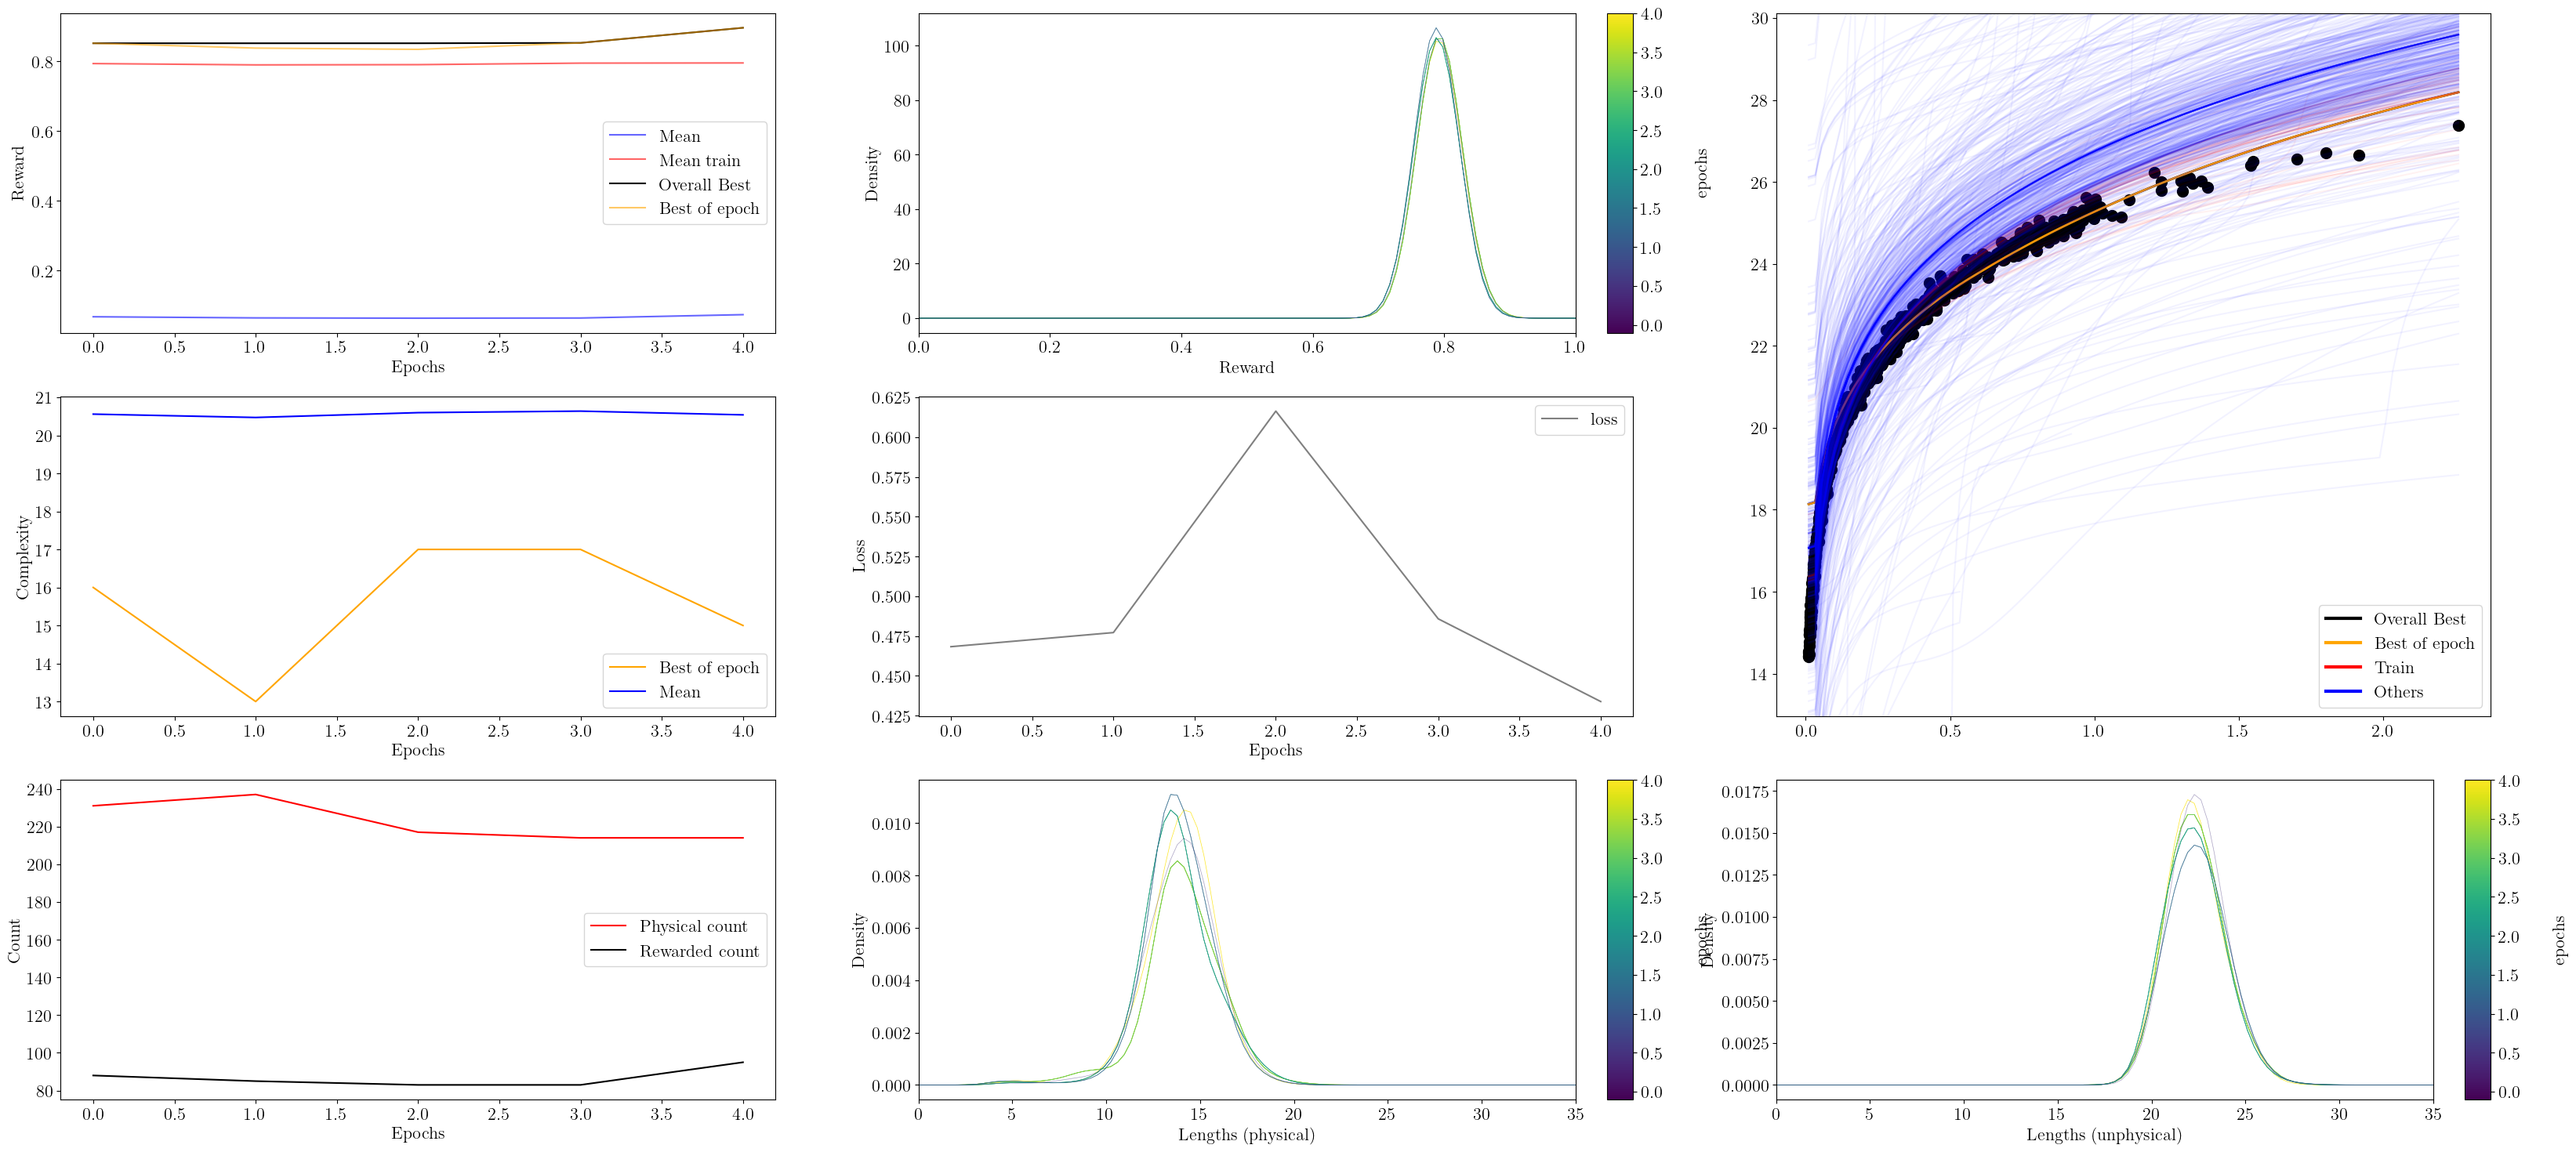

In [32]:
run_visualiser.make_visualisation()

### Pareto Front

In [33]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

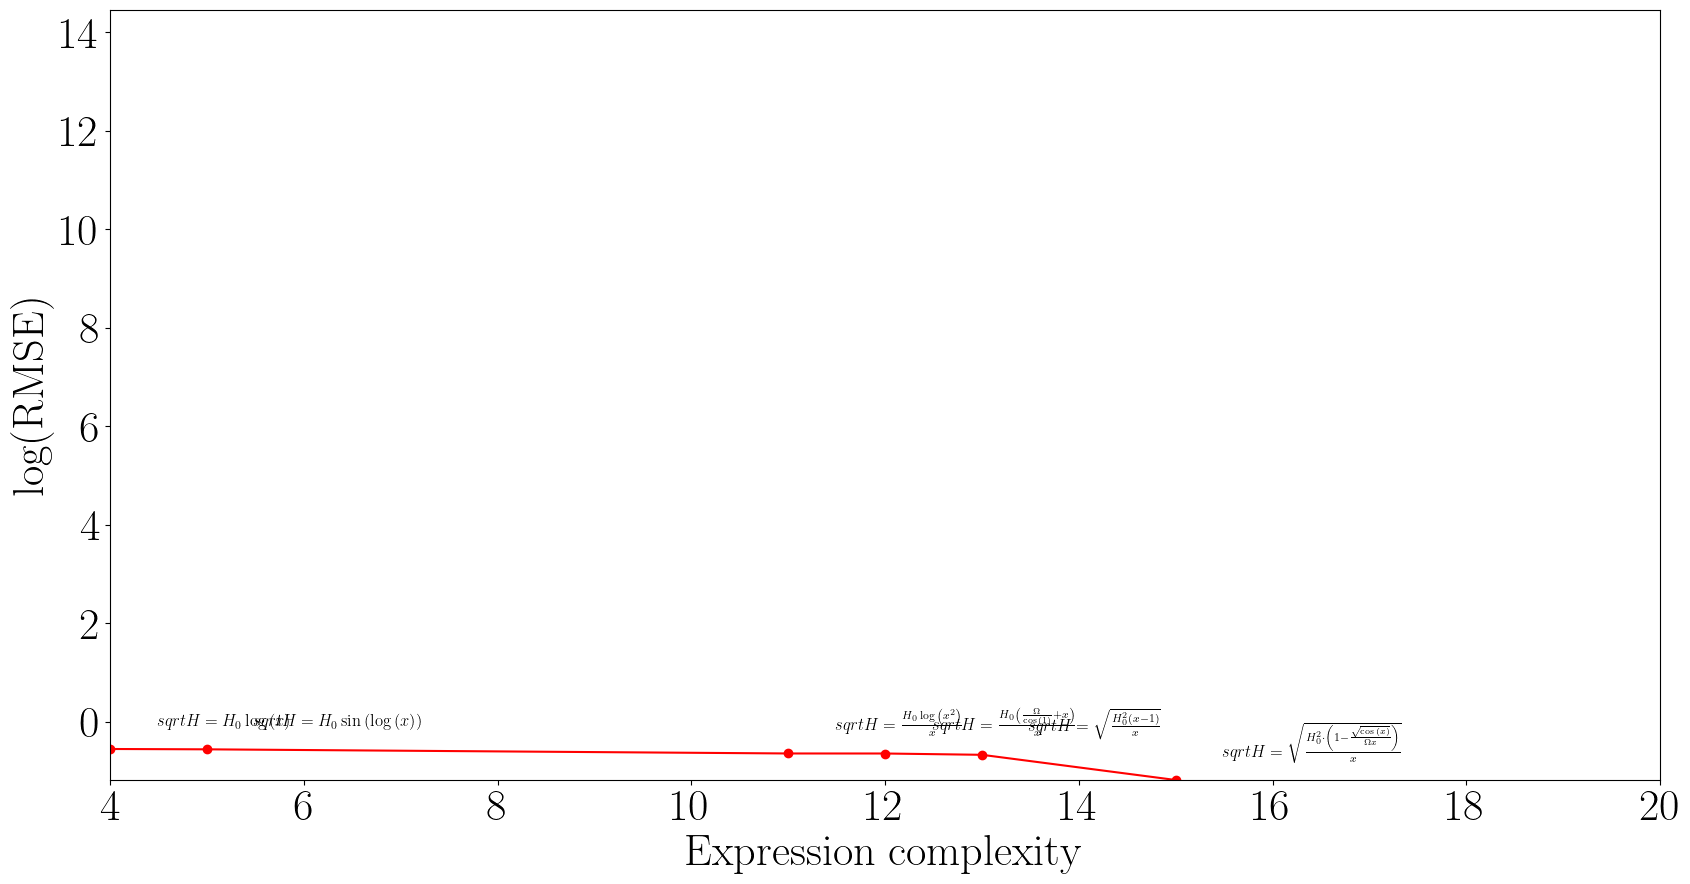

In [34]:
plot_pareto_front(run_logger)


In [35]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


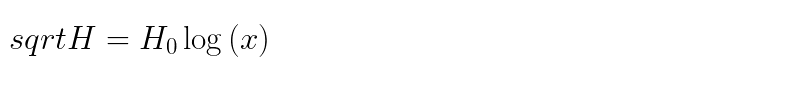

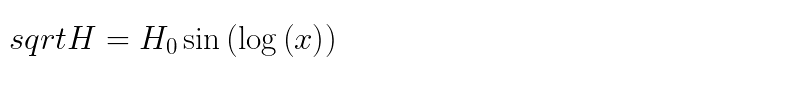

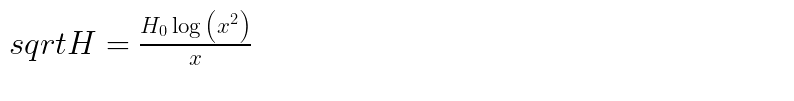

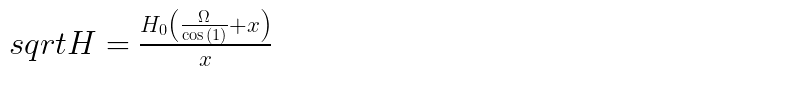

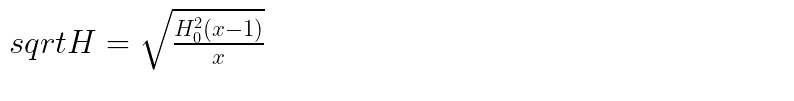

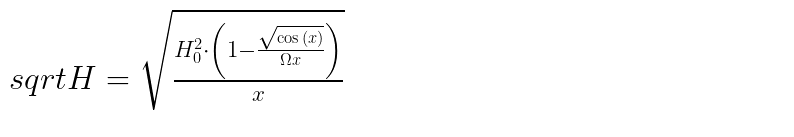

In [36]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [37]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [38]:
target_prog_sympy

H0**2*(Omega*x**3 - Omega + 1)

In [39]:
best_prog_sympy

sqrt(H0**2*(1 - sqrt(cos(x))/(Omega*x))/x)

In [40]:
target_prog_sympy == best_prog_sympy

False

In [41]:
hall_of_fame = run_logger.hall_of_fame

In [42]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

x/(((x + 1/(Omega + Omega + x + 1))**0.5/H0))
H0*(-Omega + cos((-Omega + x + x - 1*1)**0.5*exp(1)))**0.5
(1*(x - cos(x)**0.5/Omega)/(x/H0)**2)**0.5


In [43]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

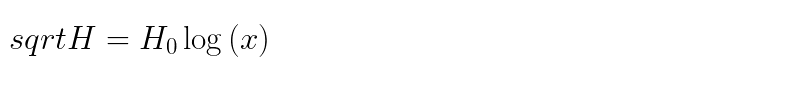

g tensor(28.2755, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


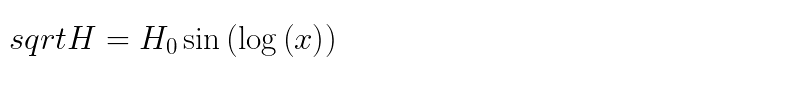

g tensor(28.4112, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


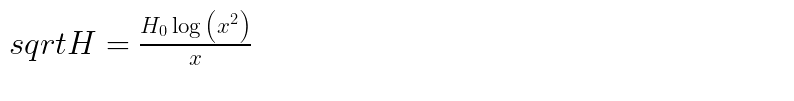

g tensor(15.9350, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


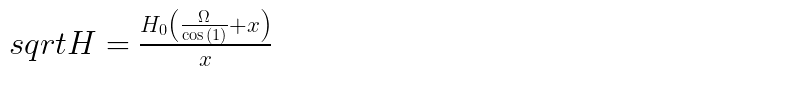

g tensor(21.2716, dtype=torch.float64)
m tensor(-0.5297, dtype=torch.float64)


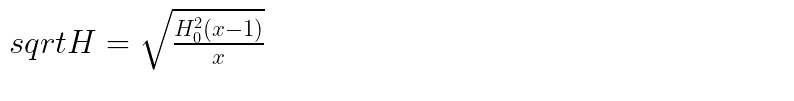

g tensor(7.7387, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


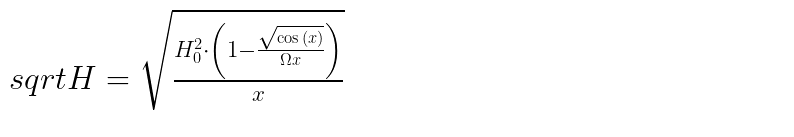

g tensor(7.7379, dtype=torch.float64)
m tensor(0.7216, dtype=torch.float64)


In [44]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])